## Tous les import nécessaires pour le projet

In [34]:
import pathlib
import cv2
import numpy as np
import os
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import random

## Import des chemins de fichiers et load des données

In [35]:

data_dir = pathlib.Path("dataset/seg_train")
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Il y a {} images dans le dataset".format(image_count))

test_data_dir = pathlib.Path("dataset/seg_test")
test_image_count = len(list(test_data_dir.glob('*/*.jpg')))
print("Il y a {} images dans le dossier de test".format(test_image_count))

dataset = []
test_dataset = []

for label in os.listdir("dataset/seg_train"):
  for filename in tqdm(os.listdir(os.path.join("dataset/seg_train",label))):
    image = cv2.imread(os.path.join("dataset/seg_train",label,filename))
    dataset.append((image, label))

for label in os.listdir("dataset/seg_test"):
  for filename in tqdm(os.listdir(os.path.join("dataset/seg_test",label))):
    image = cv2.imread(os.path.join("dataset/seg_test",label,filename))
    test_dataset.append((image, label))

Il y a 14034 images dans le dataset
Il y a 3000 images dans le dossier de test


100%|██████████| 501/501 [00:00<00:00, 2245.48it/s]


## Resizing des images (libre de choisir la taille)

In [36]:
image_size = (32, 32)
resized = []
test_resized = []

for d in dataset:
  resized.append((cv2.resize(d[0], image_size), d[1]))

for d in test_dataset:
  test_resized.append((cv2.resize(d[0], image_size), d[1]))

dataset = resized
test_dataset = test_resized

## Reshape des images pour les mettre dans un format utilisable par le SVM

In [37]:
images = np.asarray([d[0] for d in dataset])
print("images.shape avant: {}".format(images.shape))

images = images.reshape(images.shape[0], -1)
print("images.shape après: {}".format(images.shape))

# data test
test_images = np.asarray([d[0] for d in test_dataset])
print("test_images.shape avant: {}".format(test_images.shape))

test_images = test_images.reshape(test_images.shape[0], -1)
print("test_images.shape après: {}".format(test_images.shape))

images.shape avant: (14034, 32, 32, 3)
images.shape après: (14034, 3072)
test_images.shape avant: (3000, 32, 32, 3)
test_images.shape après: (3000, 3072)


## Création d'un dictionaire pour associer les labels à un chiffre

In [38]:
labels_classes_mapping = {"buildings":0,"forest":1,"glacier":2,"mountain":3,"sea":4, "street":5}

labels = np.asarray([labels_classes_mapping[d[1]] for d in dataset])
print("labels.shape: {}".format(labels.shape))

# data test
test_labels = np.asarray([labels_classes_mapping[d[1]] for d in test_dataset])
print("test_labels.shape: {}".format(test_labels.shape))

labels.shape: (14034,)
test_labels.shape: (3000,)


## Normalisation des données (pour que les valeurs soient comprises entre 0 et 1) <br>
Libre à nous de choisir la méthode de normalisation

In [39]:
# Normalisation par réduction de l'echelle
# images = images / 255.0
# test_images = test_images / 255.0

# Normalisation min-max
images = (images - images.min()) / (images.max() - images.min())
test_images = (test_images - test_images.min()) / (test_images.max() - test_images.min())

# Normalisation z-score
# images = (images - images.mean()) / images.std()
# test_images = (test_images - test_images.mean()) / test_images.std()

## On applique la méthode train_test_split pour séparer les données en train et test

In [40]:
train_x = images
train_y = labels
test_x = test_images
test_y = test_labels
#(train_x, test_x, train_y, test_y) = train_test_split(images,labels, test_size=0.2, random_state=42)

## On crée un SVM
(libre de choisir le type de SVM : 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' ou 'callable')

In [55]:

#tableau de svc pour chaque kernel
svc = [
    SVC(kernel='linear'),
    SVC(kernel='poly', degree=3),
    SVC(kernel='poly', degree=10),
    SVC(kernel='sigmoid'),
    SVC(kernel='rbf')
]

kernelType = ['linear', 'poly3', 'poly10', 'sigmoid', 'rbf']



## On entraine le SVM sur les données d'entrainement (X_train, y_train) avec la méthode fit et chaque kernel et on prédit les labels des données de test (X_test) avec la méthode predict

In [56]:
predicted_y = []
for i in tqdm(range(len(svc))):
    print("Kernel type: ", kernelType[i])
    svc[i].fit(train_x, train_y)
    predicted_y.append(svc[i].predict(test_x))

  0%|          | 0/5 [00:00<?, ?it/s]

Kernel type:  linear


 20%|██        | 1/5 [05:45<23:02, 345.74s/it]

Kernel type:  poly3


 40%|████      | 2/5 [10:03<14:42, 294.20s/it]

Kernel type:  poly10


 60%|██████    | 3/5 [15:16<10:05, 302.79s/it]

Kernel type:  sigmoid


 80%|████████  | 4/5 [23:06<06:08, 368.60s/it]

Kernel type:  rbf


100%|██████████| 5/5 [29:33<00:00, 354.71s/it]


## On calcule la précision du modèle avec les différentes méthodes (f1_score, confusion_matrix, accuracy_score)

In [57]:

for i in range(len(predicted_y)):
    print("------------- Kernel type: ", kernelType[i], "------------")
    print("Accuracy on unknown data is",accuracy_score(test_y,predicted_y[i])*100)
    print("F1 score on unknown data is",f1_score(test_y,predicted_y[i],average='weighted')*100)
    #print("Confusion matrix on unknown data is \n",confusion_matrix(test_y,predicted_y[i]))




------------- Kernel type:  linear ------------
Accuracy on unknown data is 46.266666666666666
F1 score on unknown data is 46.26890398465645
------------- Kernel type:  poly3 ------------
Accuracy on unknown data is 59.56666666666667
F1 score on unknown data is 59.32800320710311
------------- Kernel type:  poly10 ------------
Accuracy on unknown data is 50.7
F1 score on unknown data is 50.5875263092851
------------- Kernel type:  sigmoid ------------
Accuracy on unknown data is 11.733333333333333
F1 score on unknown data is 8.28980262755763
------------- Kernel type:  rbf ------------
Accuracy on unknown data is 64.03333333333333
F1 score on unknown data is 63.573081438107124


### Test avec une image random dans le folder seg_pred

In [58]:
seg_pred_dir = pathlib.Path("dataset/seg_pred")
seg_pred_image_count = len(list(seg_pred_dir.glob('*.jpg')))
print("Il y a {} images dans le dossier de test".format(seg_pred_image_count))

Il y a 7301 images dans le dossier de test


### On affiche l'image sélectionnée aléatoirement

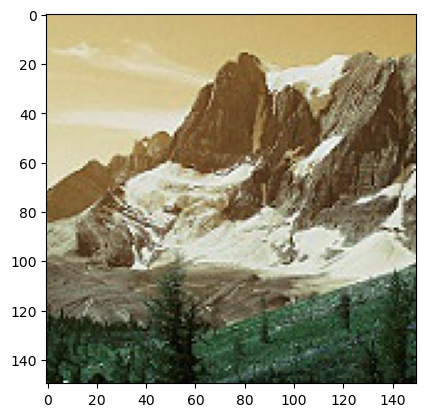

In [95]:
random_number = random.randint(0, seg_pred_image_count)
seg_pred_image = list(seg_pred_dir.glob('*.jpg'))[random_number]
seg_pred_image = cv2.imread(str(seg_pred_image))
plt.figure()
plt.imshow(seg_pred_image)

### On effectue les mêmes opérations que pour les données d'entrainement et de test (resizing, reshape, normalisation)

In [96]:
# resize the image
seg_pred_image = cv2.resize(seg_pred_image, image_size)
seg_pred_image = seg_pred_image.reshape(1, -1)

# normalisation par réduction de l'echelle
# seg_pred_image = seg_pred_image / 255.0

# normalisation min-max
seg_pred_image = (seg_pred_image - seg_pred_image.min()) / (seg_pred_image.max() - seg_pred_image.min())

# normalisation z-score
# seg_pred_image = (seg_pred_image - seg_pred_image.mean()) / seg_pred_image.std()


### On affiche le résultat de la prédiction avec chaque kernel

In [97]:
# predict the class of this image with all the kernels
for i in range(len(svc)):
    predicted_class = svc[i].predict(seg_pred_image)
    # get the class name
    for key, value in labels_classes_mapping.items():
        if value == predicted_class:
            print("predicted_class_name:", key, "---- with kernel: ", kernelType[i])

predicted_class_name: mountain ---- with kernel:  linear
predicted_class_name: glacier ---- with kernel:  poly3
predicted_class_name: mountain ---- with kernel:  poly10
predicted_class_name: buildings ---- with kernel:  sigmoid
predicted_class_name: glacier ---- with kernel:  rbf
